# Visualization notebook for GP experiments and learning

In [2]:
import sys
import os
import numpy as np
#from numpy import linalg as LA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.preprocessing import normalize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, Matern, WhiteKernel, ExpSineSquared
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, log_loss, r2_score

from scipy.linalg import expm

#from skgstat import Variogram

from joblib import dump, load

#Libraries for checkpoints during training
#from skopt import callbacks
#from skopt.callbacks import CheckpointSaver

from plotters import plot_gp, plot_gp_example, plot_residuals

In [3]:
def print_metrics(y_true, y_pred):
    """
    INPUT:
        y_true: the true measurements
        y_pred: the predicted measurements

    OUTPUT: 
        MSE, RMSE, R2
    """
    print('---------------------------\n')
    print('Metrics: \n')
    print('MAE: ' + str(mean_absolute_error(y_true, y_pred)))
    print('MSE: ' + str(mean_squared_error(y_true, y_pred, squared = False)))
    print('RMSE: ' + str(mean_squared_error(y_true, y_pred, squared = True)))
    print('R2: ' + str(r2_score(y_true, y_pred)) +'\n')
    print('---------------------------\n')

In [ ]:
checkpoint_saver = CheckpointSaver("./checkpoint.pkl", compress=9) # keyword arguments will be passed to `skopt.dump`

# Short example visualization

In [2]:
def f(x):
    """The function to predict."""
    return x * np.sin(x)

# ----------------------------------------------------------------------
#  First the noiseless case
X = np.atleast_2d([1., 3., 5., 6., 7., 8.]).T

# Observations
y1 = f(X).ravel()
dy = 0.5 + 1.0 * np.random.random(y1.shape)
noise = np.random.normal(0, dy)
y1 += noise

# Instantiate a Gaussian Process model
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
x = np.atleast_2d(np.linspace(0, 10, 1000)).T
# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y1)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

In [3]:
np.diag(sigma).shape

(1000, 1000)

In [4]:
x.shape

(1000, 1)

(1000, 1000)


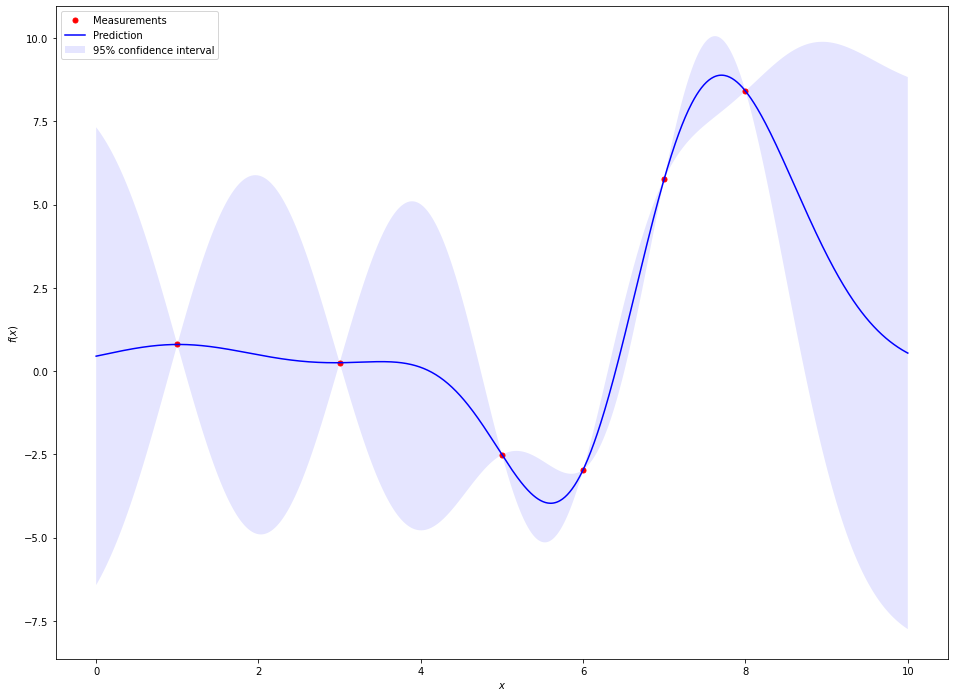

In [5]:
plot_gp_example(x, X, y1, y_pred, sigma)

# Simple time series

In [4]:
df = pd.read_csv('../data/mergedData.csv')
df.set_index('Timestamp', inplace=True)
df.index = pd.to_datetime(df.index)
df.index = df.index.to_julian_date()
#df.index = (df.index-df.index.min())/(df.index.max()-df.index.min())

In [14]:
pos1m3DO = df.loc[:,'Pos1m3DO'].dropna().iloc[:1500]

In [29]:
# List of dates for prediction, 1 minute interval
X_train, X_test, y_train, y_test = train_test_split(pos1m3DO.index.values, pos1m3DO.values , test_size=0.3)

# Specify a range (mesh) for prediction
predictionRange = np.arange(
        '2019-07-02T16:00:00.0000000',
        '2019-07-06T00:00:00.0000000',
        np.timedelta64(1, 'm'),
        dtype='datetime64'
    )

# Format inputs
X_train = X_train.reshape(len(X_train), 1)
X_test = X_test.reshape(len(X_test), 1)
#prediction_timerange = np.append(X_train, X_test)
prediction_timerange = pos1m3DO.index.values
prediction_timerange = prediction_timerange.reshape(len(prediction_timerange), 1)

predictionRange = pd.to_datetime(predictionRange).to_julian_date().values
julian_minute = predictionRange[1] - predictionRange[0]
#predictionRange = predictionRange.reshape(len(predictionRange), 1)


In [30]:
#kernel = Matern(length_scale=1.0, nu=1.0)
#kernel = ConstantKernel(1.0) * RBF(length_scale=1.0) + WhiteKernel(1.0)

matern=Matern(length_scale=0.10, length_scale_bounds=(1e-05, 100000.0), nu=2.5)
kernel = matern + ExpSineSquared(periodicity= (julian_minute * 745)) + WhiteKernel()
#ExpSineSquared(lenght_scale = )
gpr = GaussianProcessRegressor(
    kernel=kernel, 
    n_restarts_optimizer=9, 
    normalize_y=True,
    alpha=0.1
)

In [26]:
sample_size = 4000
step_size = 2

In [31]:
#gp1_prior_samples = gp1.sample_y(X = X, n_samples=train.shape[0])
gpr.fit(X_train, y_train)
#gpr_prior_samples = gpr.sample_y(X= timeList[:600], n_samples = 1).T
#Posterior predictive mean and covariance
y_pred, y_cov = gpr.predict(prediction_timerange, return_cov=True)

In [18]:
#y_pred, y_cov = gpr.predict(prediction_timerange, return_cov=True)
y_pred, y_cov = gpr.predict(X_test, return_cov=True)

In [8]:
#plt.plot(X_train, y_train, linestyle='none', marker='o', markersize=3, color='r')
#plt.plot(X_test, y_test)
gpr.kernel_

Matern(length_scale=1.23e+03, nu=2.5) + ExpSineSquared(length_scale=0.394, periodicity=0.734) + WhiteKernel(noise_level=1e-05)

In [28]:
#gpr.score(X_test,y_test)
print_metrics(y_test, y_pred)

---------------------------

Metrics: 

MAE: 0.11611976404920597
MSE: 0.16467116203294763
RMSE: 0.027116591605281293
R2: 0.9677530165975983

---------------------------



(1000,)


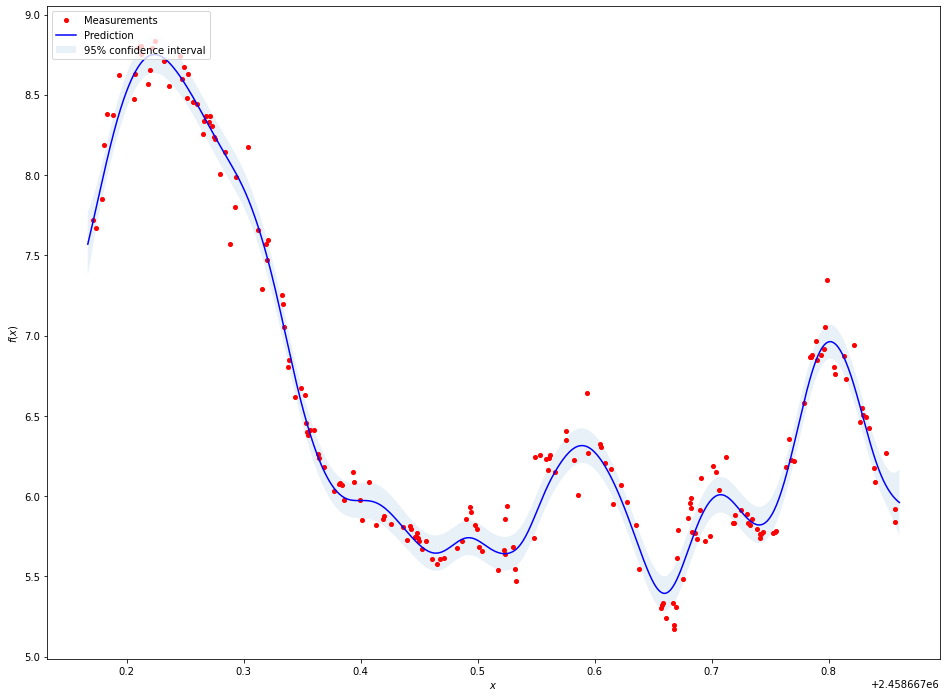

In [48]:
plot_gp(prediction_timerange, X_test, y_test, y_pred, y_cov)
#plot_gp(X_test, X_test, y_test, y_pred, y_cov)

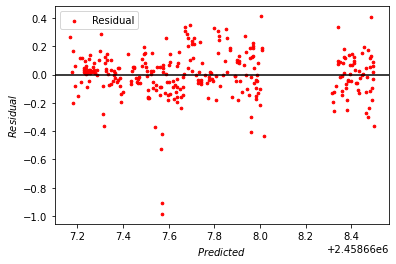

In [26]:
plot_residuals(X_test, (y_test-y_pred))

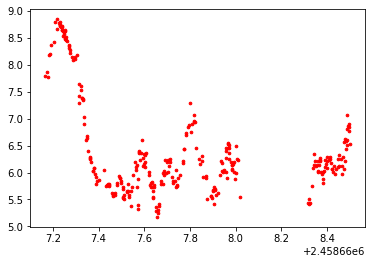

In [27]:
plt.scatter(X_test, y_test, s=7, marker ='o', color='r', label='Residual')

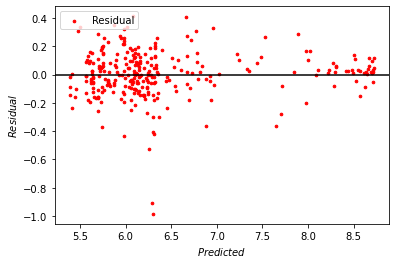

In [25]:
plot_residuals(y_pred, (y_test-y_pred))

# Spatial Gaussian Process

In [17]:
#sdf = df.loc[:,['Pos1m3DO','Pos1m6DO','Pos1m9DO','Pos1m12DO']]
sdf = df[[col for col in df.columns if 'm3' in col and 'DO' in col]]
sdf.head()

,Pos1m3DO,Pos4m3DO,Pos5m3DO,Pos6m3DO,Pos7m3DO,Outsidem3DO,Northm3DO,SouthOutsidem3DO,Southm3DO
Timestamp,,,,,,,,,
2.458667e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.458667e+06,NaN,NaN,NaN,NaN,NaN,NaN,66.17786,101.4250,80.37461
2.458667e+06,NaN,NaN,NaN,NaN,NaN,NaN,65.97083,103.6134,75.06496
2.458667e+06,NaN,NaN,NaN,NaN,NaN,NaN,66.96149,103.8499,81.00690
2.458667e+06,NaN,NaN,NaN,NaN,NaN,NaN,69.74327,104.4416,79.32155


In [5]:
depth = np.linspace(3, 12, sdf.shape[1])
sdf.dropna().iloc[0].values

array([7.797962, 7.731082, 7.848091, 8.460084])

In [6]:
# List of dates for prediction, 1 minute interval
X = depth
#X_train = train.index.values
y = sdf.dropna().iloc[0].values
#y_train = train.values

# Specify a range (mesh) for prediction
predictionRange = np.arange(
        '2019-07-02T16:00:00.0000000',
        '2019-07-06T00:00:00.0000000',
        np.timedelta64(30, 's'),
        dtype='datetime64'
    )

# Format inputs
X = X.reshape(len(X), 1)
#predictionRange = pd.to_datetime(predictionRange).to_julian_date().values

predictionRange = np.linspace(2,13,100)
predictionRange = predictionRange.reshape(len(predictionRange), 1)


#X = [pd.to_numeric(time, downcast='float') for time in X]
#predictionRange = [pd.to_numeric(time, downcast='float') for time in predictionRange]

X_and_predictionRange = [*X, *predictionRange]

In [7]:
#kernel = Matern(length_scale=1.0, nu=1.0)
#kernel = ConstantKernel(1.0) * RBF(length_scale=1.0) + WhiteKernel(1.0)
length_scale_param=0.0015
length_scale_bounds_param=(1e-05, 100000.0)
nu_param=2.5

matern=Matern(length_scale=length_scale_param, length_scale_bounds=length_scale_bounds_param, nu=nu_param)
kernel = ConstantKernel(0.5) * RBF()

sgpr = GaussianProcessRegressor(
    kernel=kernel, 
    n_restarts_optimizer=9, 
    normalize_y=True,
    alpha = 0.05
)

In [8]:
#gp1_prior_samples = gp1.sample_y(X = X, n_samples=train.shape[0])
sgpr.fit(X, y)
#gpr_prior_samples = gpr.sample_y(X= timeList[:600], n_samples = 1).T
#Posterior predictive mean and covariance
y_pred, y_cov = sgpr.predict(predictionRange, return_cov=True)
sgpr.kernel_

1**2 * RBF(length_scale=1.94)

In [110]:
sgpr.kernel_

1**2 * RBF(length_scale=1.94)

(100,)


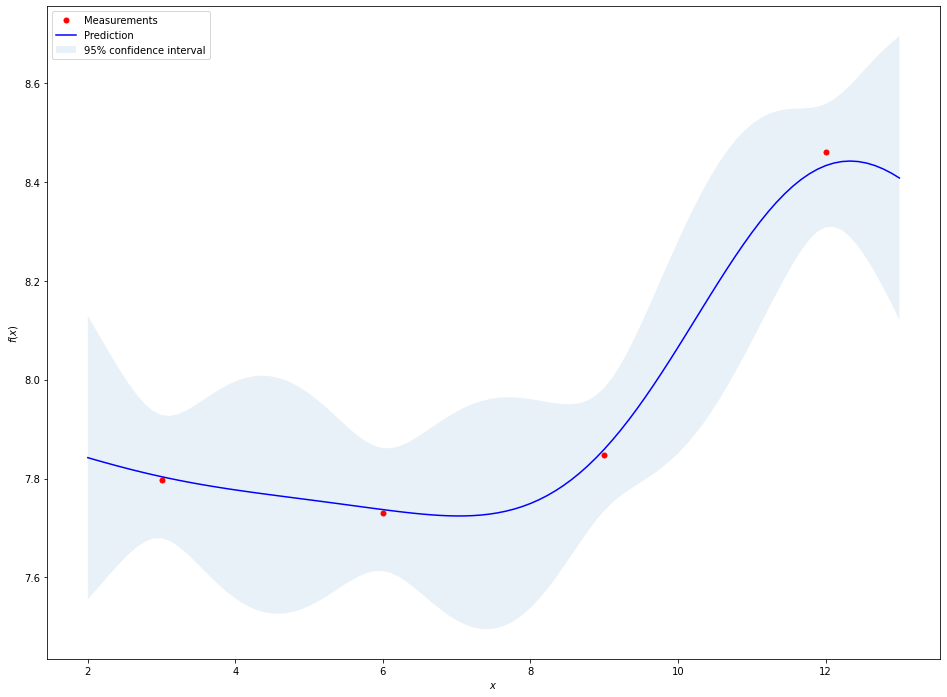

In [342]:
plot_gp(predictionRange, X, y, y_pred, y_cov)

# Spatio-Temporal Gaussian Process

## Depth and time 

In [8]:
stdf = df.loc[:,['Pos1m3DO','Pos1m6DO','Pos1m9DO','Pos1m12DO']].dropna(axis = 0, how = 'all')
stdf = stdf.iloc[:100]
y_train, y_test = train_test_split(stdf, test_size=0.2)

In [9]:
#kernel = Matern(length_scale=1.0, nu=1.0)
#kernel = ConstantKernel(1.0) * RBF(length_scale=1.0) + WhiteKernel(1.0)
length_scale_param=0.0015
length_scale_bounds_param=(1e-05, 100000.0)
nu_param=2.5

matern=Matern(length_scale=length_scale_param, length_scale_bounds=length_scale_bounds_param, nu=nu_param)
kernel = RBF(length_scale=[2.0, 0.015]) + ExpSineSquared() + WhiteKernel()

stgpr = GaussianProcessRegressor(
    kernel=kernel, 
    n_restarts_optimizer=20, 
    normalize_y=True,
    #alpha = 0.05,
    #n_jobs = -1
)

In [10]:
X= []
for col in stdf.columns:
    depth = int(re.search('m\d+', col).group()[1:])
    X.extend([(depth, timestamp) for  timestamp in stdf[col].dropna().index])

X = np.array(X)
y = stdf.values.ravel('F')[~np.isnan(stdf.values.ravel('F'))]

# Specify a range (mesh) for prediction
prediction_timerange = np.arange(
        '2019-07-02T16:00:00.0000000',
        '2019-07-06T00:00:00.0000000',
        np.timedelta64(30, 's'),
        dtype='datetime64'
    )
prediction_timerange = pd.to_datetime(prediction_timerange).to_julian_date().values
#prediction_timerange = prediction_timerange.reshape(len(prediction_timerange), 1)

prediction_spacerange = np.linspace(2,13,55)

prediction_mesh = [(3.0, timestamp) for timestamp in prediction_timerange]
prediction_mesh = np.array(prediction_mesh)
# Format inputs
#X.reshape(-1, 1)
#np.set_printoptions(precision=16)


In [216]:
stgpr.kernel_

RBF(length_scale=[3.23, 0.0041]) + WhiteKernel(noise_level=0.0606)

In [212]:
prediction_mesh = [(depth, X[50][1]) for depth in prediction_spacerange]
prediction_mesh = np.array(prediction_mesh)

In [213]:
stgpr.fit(X, y)
#joblib.dump(stgpr, 'stgpr1_1')

C:\Users\moesk\anaconda3\envs\oxygenModel\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GaussianProcessRegressor(kernel=RBF(length_scale=[2, 0.015]) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=20, normalize_y=True)

In [214]:
y_pred, y_cov = stgpr.predict(prediction_mesh, return_cov=True)

In [228]:
stgpr.score(X,y)

0.9499425438991798

(55,)


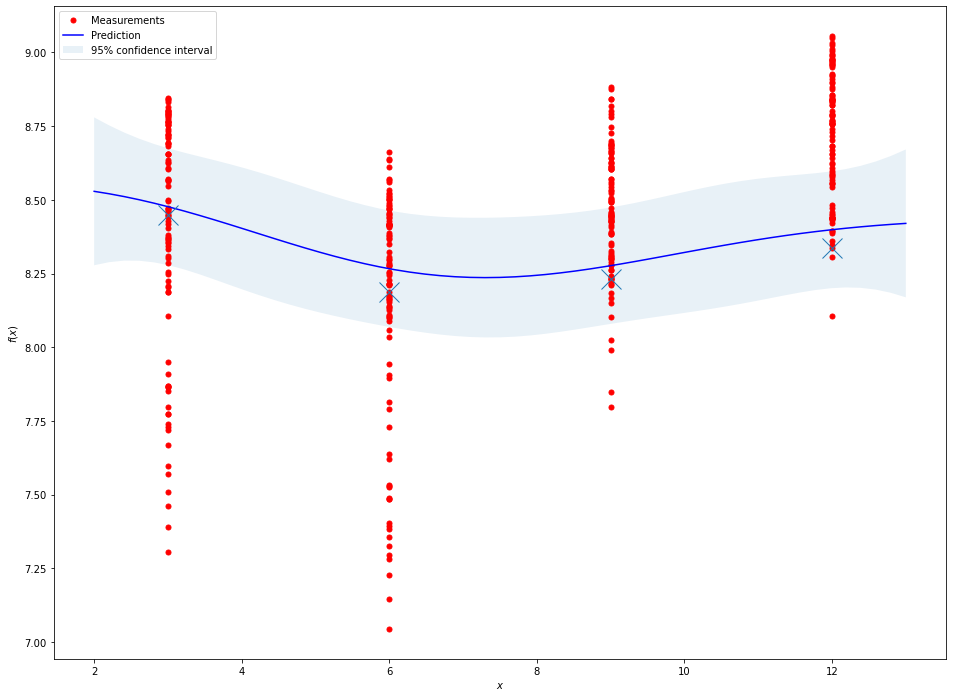

In [215]:
plot_gp(prediction_spacerange, [depth[0] for depth in X], y, y_pred, y_cov)
plt.plot(np.linspace(3, 12, 4), stdf.iloc[50].values, marker='x', linestyle='none', markersize =20.0)
#save fig

## Long, lat and Time

In [5]:
DOm3columns = [col for col in df.columns if 'm3' in col and 'DO' in col]

stdf = df.loc[:,DOm3columns].dropna(axis = 0, how = 'all')
stdf = stdf.iloc[:100]

y_train, y_test = train_test_split(stdf, test_size=0.2)

In [ ]:
X= []
for col in stdf.columns:
    depth = int(re.search('m\d+', col).group()[1:])
    X.extend([(depth, timestamp) for  timestamp in stdf[col].dropna().index])

X = np.array(X)
y = stdf.values.ravel('F')[~np.isnan(stdf.values.ravel('F'))]

# Specify a range (mesh) for prediction
prediction_timerange = np.arange(
        '2019-07-02T16:00:00.0000000',
        '2019-07-06T00:00:00.0000000',
        np.timedelta64(30, 's'),
        dtype='datetime64'
    )
prediction_timerange = pd.to_datetime(prediction_timerange).to_julian_date().values
#prediction_timerange = prediction_timerange.reshape(len(prediction_timerange), 1)

prediction_spacerange = np.linspace(2,13,55)

prediction_mesh = [(3.0, timestamp) for timestamp in prediction_timerange]
prediction_mesh = np.array(prediction_mesh)
# Format inputs
#X.reshape(-1, 1)
#np.set_printoptions(precision=16)

In [36]:
def a(type):
    if type =='a':
        def kernel(x1, x2):
            print(x1)
            print(x2)
    else:
        def kernel(x1, x2):
            print('No kernel')
    return kernel

def b(x1, x2, func):
    c = func(x1,x2)
    return c

In [41]:
#a('a')
b(1,3,a('a'))

1
3
